(2593, 10, 6)
(2593, 10, 90)
('second level AUC: ', 0.5587167008634712, 'munual AUC = ', 0.5699241822540932)
('second level AUC: ', 0.6758675521136653, 'munual AUC = ', 0.6863145594533848)
('manual_auc(0.6-second_mean_overlap1)', array([0.83394087, 0.67161516, 0.59098247, 0.55228949, 0.53040924,
       0.51297141, 0.50096397, 0.49825277, 0.50017428, 0.50764216]))
FoV:[120,120], Ae:[120,120]
('frame AUC = ', 0.5694674811917014)
('munual AUC = ', 0.5699241822540934)
FoV:[120,120], Ae:[150,150]
('frame AUC = ', 0.6859123737244852)
('munual AUC = ', 0.6863145594533848)


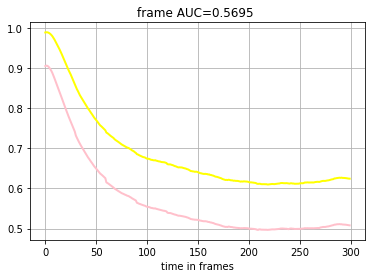

In [8]:
"""
Define IoU loss (alpha)
hit rate = alpha*gamma
"""
import numpy as np
from dataIO import xyz2thetaphi
from sklearn.metrics import auc
import cPickle as pickle
import matplotlib.pyplot as plt
import pdb
# import matplotlib.style
# import matplotlib as mpl
# mpl.style.use('classic')

predict_step = 10 #cfg.predict_step
def manual_auc(mean_overlap):
    return np.sum(1./len(mean_overlap)*mean_overlap)

def bbox_overlaps(boxes, query_boxes):
    """
    Parameters
    ----------
    boxes: (N, 4) ndarray of float
    query_boxes: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    N = boxes.shape[0]
    K = query_boxes.shape[0]
    overlaps = np.zeros((N, K))
    for k in range(K):
        box_area = (
            (query_boxes[k, 2] - query_boxes[k, 0]) *
            (query_boxes[k, 3] - query_boxes[k, 1])
        )
        for n in range(N):
            iw = (
                min(boxes[n, 2], query_boxes[k, 2]) -
                max(boxes[n, 0], query_boxes[k, 0])
            )
            if iw > 0:
                ih = (
                    min(boxes[n, 3], query_boxes[k, 3]) -
                    max(boxes[n, 1], query_boxes[k, 1])
                )
                if ih > 0:
                    ua = float(
                        (boxes[n, 2] - boxes[n, 0]) *
                        (boxes[n, 3] - boxes[n, 1]) +
                        box_area - iw * ih
                    )
                    # print 'box_area ',box_area,'   ua ',ua
                    overlaps[n, k] = iw * ih / ua
    return overlaps

def bbox_overlaps_hit_rate(boxes, query_boxes):
    """
    compute the hit rate: intersection over gt region size
    """
    N = boxes.shape[0]
    K = query_boxes.shape[0]
    overlaps = np.zeros((N, K))
    for k in range(K):
        box_area = (
            (query_boxes[k, 2] - query_boxes[k, 0]) *
            (query_boxes[k, 3] - query_boxes[k, 1])
        )
        for n in range(N):
            iw = (
                min(boxes[n, 2], query_boxes[k, 2]) -
                max(boxes[n, 0], query_boxes[k, 0])
            )
            if iw > 0:
                ih = (
                    min(boxes[n, 3], query_boxes[k, 3]) -
                    max(boxes[n, 1], query_boxes[k, 1])
                )
                if ih > 0:
                    overlaps[n, k] = iw * ih / box_area
    return overlaps


def boundary_cases(gt_centroid,centroid):
    condition1 = (gt_centroid[0]>2/3.0*np.pi)*(centroid[0]<-2/3.0*np.pi)
    centroid[0][condition1] = centroid[0][condition1]+2*np.pi

    condition2 = (gt_centroid[0]<-2/3.0*np.pi)*(centroid[0]>2/3.0*np.pi)
    gt_centroid[0][condition2] = gt_centroid[0][condition2]+2*np.pi

    # up and down doesn't have overlapping!!
    # condition3 = (gt_centroid[1]>1/2.0*np.pi)*(centroid[1]<-1/2.0*np.pi)
    # centroid[1][condition3] = centroid[1][condition3]+np.pi
    # condition4 = (gt_centroid[1]<-1/2.0*np.pi)*(centroid[1]>1/2.0*np.pi)
    # gt_centroid[1][condition4] = gt_centroid[1][condition4]+np.pi
    
    return np.array(gt_centroid),np.array(centroid)


def cut_tail(gt_centroid,centroid):
    """when video ends, there are no gt available"""
    # condition = numpy.logical_not((gt_centroid[0]==(1e-3))*(gt_centroid[1]==(1e-3)))
    condition = numpy.logical_not((gt_centroid[0]==0)*(gt_centroid[1]==0))
    return [gt_centroid[0][condition],gt_centroid[1][condition]], [centroid[0][condition],centroid[1][condition]]



def boundary_mod_2pi(centroid):
    """handle boundary conditions using modular"""
    centroid[0] = np.mod(centroid[0]+np.pi,2*np.pi)
    # up and down doesn't have overlapping!!
    # centroid[1] = np.mod(centroid[1]+np.pi,2*np.pi)
    return centroid



def get_iou_or_hitrate(centroid, span, gt_centroid, gt_span):
    """use or bbox_overlaps bbox_overlaps_hit_rate"""
    """gt_region spans (120,90) degree
    centroid: (yaw, pitch)
    span: predicted (delta_yaw,delta_pitch)
    """
    # x1,y1,x2,y2
    predicted_box = np.array([centroid[0]-span[0]/2,centroid[1]-span[1]/2,
                    centroid[0]+span[0]/2,centroid[1]+span[1]/2]).T

    gt_region = np.array([gt_centroid[0]-gt_span[0]/2,gt_centroid[1]-gt_span[1]/2,
                gt_centroid[0]+gt_span[0]/2,gt_centroid[1]+gt_span[1]/2]).T

    assert predicted_box.shape[1]==4
    assert gt_region.shape[1]==4
    overlaps = []
    for ii in range(gt_region.shape[0]):
        ### Intersection/gt area
        overlaps.append(bbox_overlaps_hit_rate(predicted_box[ii,:][np.newaxis,:],gt_region[ii,:][np.newaxis,:])[0,0])
        ### IoU:
        # overlaps.append(bbox_overlaps(predicted_box[ii,:][np.newaxis,:],gt_region[ii,:][np.newaxis,:])[0,0])
    return overlaps



def compute_hitrate_main(test_out,gt_out,draw=False,predict_sample=False,evaluate_mode=None,batch_size=32,a=1):
    span = np.array([a*120,a*120])/180.0*np.pi #for now, don't predict span
    gt_span = np.array([120,120])/180.0*np.pi

    overlap_list = []
    gt_centroid_list = []
    centroid_list = []
    if draw:
        fig1,ax1 = plt.subplots(1,1)
        fig2,ax = plt.subplots(3,2)
    if test_out.shape[1]!=batch_size:
        test_out = test_out.transpose(0,2,1)
    assert gt_out.shape[1]==batch_size
    for ii in range(gt_out.shape[0]):  
        for jj in range(batch_size):
            gt_ux, gt_varx, gt_uy, gt_vary, gt_uz, gt_varz = [],[],[],[],[],[]
            ux_temp,uy_temp,uz_temp,varx_temp,vary_temp,varz_temp = [],[],[],[],[],[]
            for step in range(predict_step):
                if predict_sample:
                    ux_temp.append(np.mean(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,:,0]))
                    uy_temp.append(np.mean(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,:,1]))
                    uz_temp.append(np.mean(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,:,2]))
                    varx_temp.append(np.var(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,:,0]))
                    vary_temp.append(np.var(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,:,1]))
                    varz_temp.append(np.var(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,:,2]))
                else:
                    ux_temp.append(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,0])
                    uy_temp.append(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,1])
                    uz_temp.append(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,2])
                    varx_temp.append(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,3])
                    vary_temp.append(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,4])
                    varz_temp.append(test_out[ii*predict_step:(ii+1)*predict_step,jj,:][step,5])

                if evaluate_mode=='second':
                    gt_ux.append(np.mean(gt_out[ii,jj,step*30:(step+1)*30,0]))
                    gt_varx.append(np.var(gt_out[ii,jj,step*30:(step+1)*30,0]))
                    gt_uy.append(np.mean(gt_out[ii,jj,step*30:(step+1)*30,1]))
                    gt_vary.append(np.var(gt_out[ii,jj,step*30:(step+1)*30,1]))
                    gt_uz.append(np.mean(gt_out[ii,jj,step*30:(step+1)*30,2]))
                    gt_varz.append(np.var(gt_out[ii,jj,step*30:(step+1)*30,2]))
                elif evaluate_mode=='frame':
                    gt_ux.append(gt_out[ii,jj,step*30:(step+1)*30,0])
                    gt_uy.append(gt_out[ii,jj,step*30:(step+1)*30,1])
                    gt_uz.append(gt_out[ii,jj,step*30:(step+1)*30,2])

            # convert predicted xyz mean into phi, theta
            utheta, uphi = xyz2thetaphi(np.array(ux_temp),np.array(uy_temp),np.array(uz_temp))
            # vartheta, varphi = xyz2thetaphi(varx,vary,varz) #??? 
            if evaluate_mode=='second':
                centroid = [utheta.copy(), uphi.copy()]
            elif evaluate_mode=='frame':
                centroid0 = []
                centroid1 = []
                for zz in range(len(utheta)):
                    centroid0.append([utheta[zz]]*30)
                    centroid1.append([uphi[zz]]*30)
                centroid = np.array([centroid0,centroid1])

            gt_utheta, gt_uphi = xyz2thetaphi(np.array(gt_ux),np.array(gt_uy),np.array(gt_uz))
            gt_centroid = [gt_utheta.copy(), gt_uphi.copy()]

            # handle boundary cases!!
            gt_centroid,centroid = boundary_cases(gt_centroid,np.squeeze(centroid))
            # or use modulo 
            # gt_centroid = boundary_mod_2pi(gt_centroid)
            # centroid = boundary_mod_2pi(centroid)

            if evaluate_mode=='second':
                overlaps = get_iou_or_hitrate(centroid, span, gt_centroid, gt_span)
            elif evaluate_mode=='frame':
                overlaps = []
                for time_ind in range(predict_step):
                    overlaps.append(get_iou_or_hitrate(centroid[:,time_ind,:], span, gt_centroid[:,time_ind,:], gt_span))

            overlap_list.append(overlaps)
            gt_centroid_list.append(gt_centroid)
            centroid_list.append(centroid)

            if draw:
                assert evaluate_mode=='second' #not implemented for frame
                # ax1.scatter(range(len(overlaps)),overlaps)
                ax1.plot(range(len(overlaps)),overlaps)
                ax1.set_ylim([-0.1,1.1])
                plt.title('overlaps')
                fig1.canvas.draw()

                # if (np.array(ux_temp)-np.array(gt_ux)).mean()>0.1:
                ax[0,0].scatter(range(predict_step),ux_temp,color='r')
                ax[0,0].scatter(range(predict_step),gt_ux,color='g')
                ax[0,0].set_ylim([min(gt_ux)-0.2,max(gt_ux)+0.2])
                ax[0,1].scatter(range(predict_step),varx_temp,color='r')
                ax[0,1].scatter(range(predict_step),gt_varx,color='g')
                ax[0,1].set_ylim([-0.05,0.05])

                ax[1,0].scatter(range(predict_step),uy_temp,color='r')
                ax[1,0].scatter(range(predict_step),gt_uy,color='g')
                ax[1,0].set_ylim([min(gt_uy)-0.2,max(gt_uy)+0.2])
                ax[1,1].scatter(range(predict_step),vary_temp,color='r')
                ax[1,1].scatter(range(predict_step),gt_vary,color='g')
                ax[1,1].set_ylim([-0.05,0.05])


                ax[2,0].scatter(range(predict_step),uz_temp,color='r')
                ax[2,0].scatter(range(predict_step),gt_uz,color='g')
                ax[2,0].set_ylim([min(gt_uz)-0.2,max(gt_uz)+0.2])
                ax[2,1].scatter(range(predict_step),varz_temp,color='r')
                ax[2,1].scatter(range(predict_step),gt_varz,color='g')
                ax[2,1].set_ylim([-0.05,0.05])

                plt.draw()
                pdb.set_trace()
                ax1.cla()
                ax[0,0].cla()
                ax[0,1].cla()
                ax[1,0].cla()
                ax[1,1].cla()
                ax[2,0].cla()
                ax[2,1].cla()
    return overlap_list,gt_centroid_list,centroid_list


def _draw_result_curve(overlap_list,evaluate_mode,tag=''):
    overlap_list = np.array(overlap_list)
    predict_step = overlap_list.shape[1]
    mean_overlap = np.mean(overlap_list,axis=0)
    if evaluate_mode=='second':
        plt.figure()
        plt.plot(range(1,predict_step+1),mean_overlap)
        plt.scatter(range(1,predict_step+1),mean_overlap)
        plt.xlabel('time in seconds')

    if evaluate_mode=='frame':
        mean_overlap_flat = mean_overlap.reshape(predict_step*30,-1)
        plt.figure()
        plt.plot(range(1,predict_step*30+1),mean_overlap_flat)
        plt.scatter(range(15,predict_step*30+15,30),np.mean(mean_overlap,axis=1))
        mean_overlap = mean_overlap_flat
        plt.xlabel('time in frames')

    xaxis = np.linspace(0,1,len(mean_overlap))
    areaunder = auc(xaxis,mean_overlap)
    plt.title(' AUC='+"%.04f "%areaunder+tag)
    plt.ylabel('hitrate')
    print('AUC = ',areaunder)
    print('munual AUC = ',manual_auc(mean_overlap))
    plt.grid('on')
    plt.xlim(0,10)


def get_gt_target_xyz(y):
    """get gt mean var"""
    target_x = y[:,:,0::3]
    target_y = y[:,:,1::3]
    target_z = y[:,:,2::3]
    gt_mean_x = np.mean(target_x, axis=2)[:,:,np.newaxis]
    gt_var_x = np.var(target_x, axis=2)[:,:,np.newaxis]
    gt_mean_y = np.mean(target_y, axis=2)[:,:,np.newaxis]
    gt_var_y = np.var(target_y, axis=2)[:,:,np.newaxis]
    gt_mean_z = np.mean(target_z, axis=2)[:,:,np.newaxis]
    gt_var_z = np.var(target_z, axis=2)[:,:,np.newaxis]
    return np.concatenate((gt_mean_x,gt_mean_y,gt_mean_z,gt_var_x,gt_var_y,gt_var_z),axis=2)




def _eval_for_seq2seq(test_out,gt_out,draw=False,a=1,evaluate_mode='frame'):
    """gt shape: N*5*90
       test shape: N*5*6
    """
    predict_step = gt_out.shape[1]
    assert predict_step==10

    if draw:
        fig2,ax = plt.subplots(3,2)
    span = np.array([a*120,a*120])/180.0*np.pi #for now, don't predict span
    gt_span = np.array([120,120])/180.0*np.pi
    overlap_list = []
    gt_centroid_list = []
    centroid_list = []
    for ii in range(gt_out.shape[0]):
        if gt_out.shape[-1]==6:#already in mean,var
            gt_ux,gt_uy,gt_uz,gt_varx,gt_vary,gt_varz = np.split(gt_out[ii,:,:],6,axis=1)
            gt_ux = np.repeat(gt_ux,30,axis=1)
            gt_uy = np.repeat(gt_uy,30,axis=1)
            gt_uz = np.repeat(gt_uz,30,axis=1)
        else:
            gt_ux = gt_out[ii,:,0::3]
            gt_uy = gt_out[ii,:,1::3]
            gt_uz = gt_out[ii,:,2::3]

        ux_temp,uy_temp,uz_temp,varx_temp,vary_temp,varz_temp = np.split(test_out[ii,:,:],6,axis=1)
        # convert predicted xyz mean into phi, theta
        utheta, uphi = xyz2thetaphi(np.array(ux_temp),np.array(uy_temp),np.array(uz_temp))
        # vartheta, varphi = xyz2thetaphi(varx,vary,varz) #??? 
        if evaluate_mode=='second':
            centroid = [utheta.copy(), uphi.copy()]
        elif evaluate_mode=='frame':
            centroid0 = []
            centroid1 = []
            for zz in range(len(utheta)):
                centroid0.append([utheta[zz]]*30)
                centroid1.append([uphi[zz]]*30)
            centroid = np.array([centroid0,centroid1])

        gt_utheta, gt_uphi = xyz2thetaphi(np.array(gt_ux),np.array(gt_uy),np.array(gt_uz))
        gt_centroid = [gt_utheta.copy(), gt_uphi.copy()]
        ## if evaluate at all frame level:

        # handle boundary cases!!
        gt_centroid,centroid = boundary_cases(gt_centroid,np.squeeze(centroid))
        # or use modulo 
        # gt_centroid = boundary_mod_2pi(gt_centroid)
        # centroid = boundary_mod_2pi(centroid)

        if evaluate_mode=='second':
            overlaps = get_iou_or_hitrate(centroid, span, gt_centroid, gt_span)
        elif evaluate_mode=='frame':
            overlaps = []
            for time_ind in range(predict_step):
                overlaps.append(get_iou_or_hitrate(centroid[:,time_ind,:], span, gt_centroid[:,time_ind,:], gt_span))

        overlap_list.append(overlaps)
        gt_centroid_list.append(gt_centroid)
        centroid_list.append(centroid)

        if draw:
            ax[0,0].scatter(range(0,predict_step*30,30),ux_temp,color='r')
            ax[0,0].scatter(range(predict_step*30),gt_ux,color='g')
            # ax[0,0].set_ylim([min(gt_ux)-0.2,max(gt_ux)+0.2])
            # ax[0,1].scatter(range(0,predict_step*30,30),varx_temp,color='r')
            # ax[0,1].scatter(range(predict_step*30),gt_varx,color='g')
            # ax[0,1].set_ylim([-0.05,0.05])

            ax[1,0].scatter(range(0,predict_step*30,30),uy_temp,color='r')
            ax[1,0].scatter(range(predict_step*30),gt_uy,color='g')
            # ax[1,0].set_ylim([min(gt_uy)-0.2,max(gt_uy)+0.2])
            # ax[1,1].scatter(range(0,predict_step*30,30),vary_temp,color='r')
            # ax[1,1].scatter(range(predict_step*30),gt_vary,color='g')
            # ax[1,1].set_ylim([-0.05,0.05])


            ax[2,0].scatter(range(0,predict_step*30,30),uz_temp,color='r')
            ax[2,0].scatter(range(predict_step*30),gt_uz,color='g')
            # ax[2,0].set_ylim([min(gt_uz)-0.2,max(gt_uz)+0.2])
            # ax[2,1].scatter(range(0,predict_step*30,30),varz_temp,color='r')
            # ax[2,1].scatter(range(predict_step*30),gt_varz,color='g')
            # ax[2,1].set_ylim([-0.05,0.05])

            plt.draw()
            pdb.set_trace()
            ax[0,0].cla()
            ax[0,1].cla()
            ax[1,0].cla()
            ax[1,1].cla()
            ax[2,0].cla()
            ax[2,1].cla()
    return overlap_list,gt_centroid_list,centroid_list


def compute_hitrate_given_thetaphi(gt_utheta, gt_uphi, theta, phi,a=1,evaluate_mode='frame'):
    """given theta phi in 30 frames"""
    # gt_utheta.shape = (1632, 10, 30)
    span = np.array([a*120,a*120])/180.0*np.pi
    gt_span = np.array([120,120])/180.0*np.pi

    gt_centroid = [gt_utheta, gt_uphi]
    centroid = [theta, phi]
    # handle boundary cases!!
    gt_centroid,centroid = boundary_cases(gt_centroid,np.squeeze(centroid))
    # or use modulo 
    # gt_centroid = boundary_mod_2pi(gt_centroid)
    # centroid = boundary_mod_2pi(centroid)

    overlap_list = []
    gt_centroid_list = []
    centroid_list = []
    for ii in range(gt_utheta.shape[0]):
        if evaluate_mode=='second':
            overlaps = get_iou_or_hitrate(np.mean(centroid[:,ii,:],axis=-1), span, np.mean(gt_centroid[:,ii,:],axis=-1), gt_span)
        elif evaluate_mode=='frame':
            overlaps = []
            for time_ind in range(predict_step):
                overlaps.append(get_iou_or_hitrate(centroid[:,ii,time_ind,:], span, gt_centroid[:,ii,time_ind,:], gt_span))

        overlap_list.append(overlaps)
        gt_centroid_list.append(gt_centroid)
        centroid_list.append(centroid)
    return overlap_list,gt_centroid_list,centroid_list




def _draw_two_result_curve(overlap_list1, overlap_list2, evaluate_mode, c1='r',c2='g',marker=None, fps=30):
    overlap_list1 = np.array(overlap_list1)
    overlap_list2 = np.array(overlap_list2)
    mean_overlap1 = np.mean(overlap_list1,axis=0)
    mean_overlap2 = np.mean(overlap_list2,axis=0)

    std_across_user = np.std(overlap_list1,axis=0)
    # std1 = np.mean(std_across_user,axis=1)
    second_mean_overlap1 = np.mean(mean_overlap1,axis=1)
    second_mean_overlap2 = np.mean(mean_overlap2,axis=1)  
    if evaluate_mode=='second':      
        line1, = plt.plot(range(1,1+predict_step),second_mean_overlap1,c1,label='a=1',linewidth=2,marker=marker)
        # plt.fill_between(range(1,1+predict_step), second_mean_overlap1-std1, second_mean_overlap1+std1, alpha=0.3,facecolor=c1)
        line2, = plt.plot(range(1,1+predict_step),second_mean_overlap2,c2,label='a=1.25',linewidth=2,marker=marker)
    
        # plt.scatter(np.arange(predict_step),second_mean_overlap1,color=c1)
        # plt.scatter(np.arange(predict_step),second_mean_overlap2,color=c2)
        plt.xlabel('time in seconds')

    elif evaluate_mode=='frame':
        line1, = plt.plot(range((predict_step)*fps),mean_overlap1.reshape(fps*predict_step),c1,label='a=1',linewidth=2,marker=marker)
        line2, = plt.plot(range((predict_step)*fps),mean_overlap2.reshape(fps*predict_step),c2,label='a=1.25',linewidth=2,marker=marker)
        # plt.scatter(np.arange(0.5*fps,(predict_step+0.5)*fps,fps),second_mean_overlap1,color=c1)
        # plt.scatter(np.arange(0.5*fps,(predict_step+0.5)*fps,fps),second_mean_overlap2,color=c2)
        plt.xlabel('time in frames')

    #second level AUC
    xaxis = np.linspace(0,1,len(second_mean_overlap1))
    print('second level AUC: ',auc(xaxis,second_mean_overlap1),'munual AUC = ',manual_auc(second_mean_overlap1))
    print('second level AUC: ',auc(xaxis,second_mean_overlap2),'munual AUC = ',manual_auc(second_mean_overlap2))

    #frame level AUC
    xaxis = np.linspace(0,1,len(mean_overlap1.flatten()))
    frameauc1 = auc(xaxis,mean_overlap1.flatten())
    print('manual_auc(0.6-second_mean_overlap1)',second_mean_overlap1)
    print('FoV:[120,120], Ae:[120,120]')
    print('frame AUC = ',frameauc1)
    print('munual AUC = ',manual_auc(mean_overlap1.flatten()))
    plt.title('frame AUC='+"%.04f "%frameauc1)
    
    frameauc2 = auc(xaxis,mean_overlap2.flatten())

    print('FoV:[120,120], Ae:[150,150]')
    print('frame AUC = ',frameauc2)
    print('munual AUC = ',manual_auc(mean_overlap2.flatten()))
    plt.grid()
    return line1,line2,frameauc1,frameauc2


if __name__ == '__main__':
    #tag = '/Users/maojuntao/Downloads/project/'
    test_out = pickle.load(open('/Users/maojuntao/Downloads/project/decoded_sentencefctar_seqseq_THU_predmeanvar_Sep51.p','rb'))
    gt_out = pickle.load(open('/Users/maojuntao/Downloads/project/gt_sentence_listfctar_seqseq_THU_predmeanvar_Sep51.p','rb'))
    test_out = np.squeeze(np.array(test_out))
    gt_out = np.squeeze(np.array(gt_out))
    #print(test_out.shape)
    #print(gt_out.shape)

    prediction_length = 10#gt_out.shape[-3]
    gt_out = gt_out.reshape(-1,prediction_length,90)
    test_out = test_out.reshape(-1,prediction_length,6)
    print(test_out.shape)
    print(gt_out.shape)


    #------- for tensorflow format
    # (N*T, 6, batch_size)
    # (N, batch_size, fps*T, 3)
    #tag = ''
    #evaluate_mode='frame'
   # batch_size = gt_out.shape[1]
    #overlap_list,_,_ = _eval_for_seq2seq(test_out,gt_out,draw=False,a=1,evaluate_mode='frame')
    #overlap_list2,_,_ = _eval_for_seq2seq(test_out,gt_out,draw=False,a=1,evaluate_mode='frame')
    #draw 1 curves
    # _draw_result_curve(overlap_list,evaluate_mode,tag=tag)
    #draw 2 curves
    #line3,line4 = _draw_two_result_curve(overlap_list,overlap_list2,'second', tag=tag,c1='coral',c2='firebrick')
    #plt.figure()
    #line5,line6 = _draw_two_result_curve(overlap_list,overlap_list2,'frame', tag=tag,c1='pink',c2='yellow')




    #------- for keras format
    # (N, T, 6)
    # (N, T, 90)
    predict_step = test_out.shape[1]
    evaluate_mode='frame'
    overlap_list,_,_ = _eval_for_seq2seq(test_out[:,:,:],gt_out[:,:,:],draw=False,a=1)
    overlap_list2,_,_ = _eval_for_seq2seq(test_out[:,:,:],gt_out[:,:,:],draw=False,a=1.25)

    #two figures each two lines
    #plt.figure()
    #line3,line4 = _draw_two_result_curve(overlap_list,overlap_list2,'second', tag=tag,c1='coral',c2='firebrick')
    plt.figure()
    line5,line6,frameauc5,frameauc6 = _draw_two_result_curve(overlap_list,overlap_list2,'frame',c1='pink',c2='yellow')


'''
    #draw one line
    ii=0
    lines=[]
    colors= ['yellow','pink','skyblue','olive','black','green',
            'firebrick','coral','orange','magenta','purple',
            'blue','red','gray','tan','lightcoral','gold']

    # overlap_list,_,_ = _eval_for_seq2seq(test_out[:,:,:],gt_out[:,:,:],draw=False,a=1)
    overlap_list,_,_ = _eval_for_seq2seq(test_out[:,:,:],gt_out[:,:,:],draw=False,a=1.25)
    color = colors[ii]
    # _draw_result_curve(overlap_list,evaluate_mode='frame',tag=tag)
    #thisline,_ = _draw_two_result_curve(overlap_list,overlap_list,'second', tag=tag,c1=color,c2=color)
    #ii+=1
    #lines.append(thisline)



    plt.legend(lines,['convLSTM target only seqseq raw->raw'+'',
     'convLSTM target only seqseq raw->(mean and var)',
    'fctar_seqseq raw->(mean and var)',
    'fctar_seqseq (mean,var->mean,var)',
    '* fctar_seqseq_mlpmixing (mean,var->mean,var)',
    '* fctar_seqseq_mlpmixing raw->(mean and var)',
    'convLSTM target only seqseq (mean,var->mean,var)',
    'convlstm seq2seq+convlstm others (all raw->all mean,var)',
    'convlstm seq2seq+convlstm others (only others raw ->all mean,var)'])







    #------- for one-hot format, need to generate theta, phi first  
    #plot  
    evaluate_mode = 'second'
    # line1,line2 = _draw_two_result_curve(overlap_list,overlap_list2,evaluate_mode, tag=tag,c1='green',c2='black')
    #line3,line4 = _draw_two_result_curve(overlap_list,overlap_list2,evaluate_mode, tag=tag,c1='coral',c2='firebrick')
    # line5,line6 = _draw_two_result_curve(overlap_list,overlap_list2,evaluate_mode, tag=tag,c1='pink',c2='yellow')
    # line7,line8 = _draw_two_result_curve(overlap_list,overlap_list2,evaluate_mode, tag=tag,c1='skyblue',c2='olive')
    # line9,line10 = _draw_two_result_curve(overlap_list,overlap_list2,evaluate_mode, tag=tag,c1='orange',c2='magenta')
    # line11,line12 = _draw_two_result_curve(overlap_list,overlap_list2,evaluate_mode, tag=tag,c1='blue',c2='springgreen')
    #plt.xlim(1,10)
    #plt.grid('on')


    #plt.title('onehot_matrix_3layertanh_stateful_noshuffle_raw_512-1024july10')
    #plt.legend([line1,line2,line3,line4 ],[
        'eval on quantized one-hot gt centoid (phi,theta), [120,120]',
        'eval on quantized one-hot gt centoid (phi,theta), [150,150]',
        'eval on real-number frame-level gt, [120,120]',
        'eval on real-number frame-level gt, [150,150]'])


    # given theta and phi
    try:
        del overlap_list,overlap_list2
    except:
        pass
    evaluate_mode='frame'
    t1 = 0
    t2 = -1
    overlap_list,_,_ =compute_hitrate_given_thetaphi(theta_gt[t1:t2], phi_gt[t1:t2], theta_[t1:t2], phi_[t1:t2],a=1)
    overlap_list2,_,_ =compute_hitrate_given_thetaphi(theta_gt[t1:t2], phi_gt[t1:t2], theta_[t1:t2], phi_[t1:t2],a=1.25)
    evaluate_mode = 'second'
    line3,line4 = _draw_two_result_curve(overlap_list,overlap_list2,evaluate_mode, tag=tag,c1='coral',c2='firebrick')
    plt.figure()
    line5,line6 = _draw_two_result_curve(overlap_list,overlap_list2,'frame', tag=tag,c1='pink',c2='yellow')


'''





## check result with fanyi's matlab code for hitrate
## change numpy array into matlab vectors
from numpy import ndarray, unravel_index, prod
def mmat(x, format='%.12e'):
    """Display the ndarray 'x' in a format suitable for pasting to MATLAB"""

    def print_row(row, format):
        for i in row:
            print(format % i)

    if x.ndim == 1:
        # 1d input
        print("[")
        print_row(x, format)
        print("]")
        print("")

    if x.ndim == 2:
        print("[")
        print_row(x[0], format)
        if x.shape[0] > 1:
            print(';')
        for row in x[1:-1]:
            print(" ")
            print_row(row, format)
            print(";")
        if x.shape[0] > 1:
            print(" ")
            print_row(x[-1], format)
        print("]")

    if x.ndim > 2:
        d_to_loop = x.shape[2:]
        sls = [slice(None,None)]*2
        print("reshape([ ")
        # loop over flat index
        for i in range(prod(d_to_loop)):
            # reverse order for matlab
            # tricky double reversal to get first index to vary fastest
            ind_tuple = unravel_index(i,d_to_loop[::-1])[::-1]
            ind = sls + list(ind_tuple)
            mmat(x[ind],format)          

        print('],[')
        for i in x.shape:
            print('%d' % i)
        print('])')


# test_ind = 15

# print('target_user_yaw_GT_vec = '); mmat(gt_centroid_list[test_ind][0], format='%.12e');print(';')
# print('target_user_pitch_GT_vec = '); mmat(gt_centroid_list[test_ind][1], format='%.12e');print(';')

# print('target_user_yaw_PRED_vec = '); mmat(centroid_list[test_ind][0], format='%.12e');print(';')
# print('target_user_pitch_PRED_vec = '); mmat(centroid_list[test_ind][1], format='%.12e');print(';')














